Build a Reference Hierarchy for Postimees, ERR, Delfi articles

Note that for paid articles you need to provide valid cookies for Postimees and Authorization Bearer token for Delfi.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
from tqdm import tqdm  # Import tqdm for the progress bar functionality
import time
import re
from langdetect import detect, DetectorFactory
import urllib.parse

DetectorFactory.seed = 0

def is_estonian(text):
    try:
        return detect(text) == 'et'
    except Exception as e:
        #print("Language detection error:", e)
        return False

def load_cookies(file_path):
    with open(file_path, "r") as file:
        cookies = json.load(file)
    return {cookie["name"]: cookie["value"] for cookie in cookies}

def setup_session(cookies_file):
    # Load cookies and set up the session
    cookies = load_cookies(cookies_file)
    session = requests.Session()
    session.cookies.update(cookies)
    return session

def fetch_postimees_article_content(session, url, article_id):
    try:
        response = session.get(url)
        if response.status_code != 200:
            print(f"Failed to fetch {url}. Status code: {response.status_code}")
            return None

        soup = BeautifulSoup(response.text, 'html.parser')

        # Check for any element whose tag name starts with "liveblog" (e.g., <liveblog-widget>)
        liveblog_tag = soup.find(lambda tag: tag.name and tag.name.lower().startswith("liveblog"))
        if liveblog_tag:
            print(f"Skipping article at {url} because it contains a liveblog element ({liveblog_tag.name}).")
            return None
        
        article_selector = f'article[data-article-id="{article_id}"]'
        article = soup.select_one(article_selector)
        if not article:
            print(f"No article found with ID {article_id} at {url}")
            return None

        # Extract content from the article body containers
        content_items = article.find_all(
            lambda tag: tag.name == "div" and "article-body__item--htmlElement" in tag.get("class", []))
        content = []
        hrefs = []
        for container in content_items:
            paragraphs_and_headings = container.find_all(["p", "h2"])
            content.extend(element.get_text(strip=True) for element in paragraphs_and_headings)
            links = container.find_all("a", href=True)
            hrefs.extend(link["href"] for link in links 
                         if (('postimees.ee' in link['href'] or 
                              'delfi.ee/artikkel' in link['href'] or 
                              'err.ee' in link['href']) and '/comments' not in link['href']))

        content_text = ' '.join(content)

        # Check if the article is in Estonian
        if not is_estonian(content_text):
            #print(f"Skipping article at {url} because its language is not Estonian.")
            return None

        return {
            'url': url,
            'content': content_text,
            'references': hrefs
        }
    except Exception as e:
        print(f"Failed to process URL {url}: {e}")
        return None

API_URL = "https://content.api.delfi.ee/content/v3/graphql"

def clean_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    for a in soup.find_all('a'):  # Remove hyperlinks but keep the text
        a.unwrap()
    return soup.get_text(strip=True)

def fetch_delfi_article_content(session, url, article_id):
    variables = {"id": article_id}
    extensions = {
        "persistedQuery": {
            "version": 1,
            "sha256Hash": "805a5fb102a1fa46e23693593ca6994fe556d7e087edc3281cf8c940840e1daf"
        }
    }
    try:
        response = session.get(
            API_URL,
            params={
                "operationName": "portal_root_getArticleBodyByID",
                "variables": json.dumps(variables),
                "extensions": json.dumps(extensions)
            },
            timeout=10
        )

        if response.status_code == 200:
            response_json = response.json()
            article_data = response_json.get("data", {}).get("article", {}).get("data", [])
            if not article_data:
                print(f"No valid article data found for ID {article_id}.")
                return None

            article = article_data[0].get("content", {})
            paywall_access = article.get("paywall", {}).get("access", True)
            if not paywall_access:
                print(f"Article ID {article_id} is behind a paywall and cannot be accessed.")
                return None

            lead_content = article.get("lead", {}).get("content", [])
            lead_html = lead_content[0].get("html", "") if lead_content else ""
            all_text = clean_html(lead_html)

            body_content = article.get("body", {}).get("content", [])
            references = []
            soup_fragment = BeautifulSoup(lead_html, "html.parser")
            references.extend([a['href'] for a in soup_fragment.find_all('a', href=True)])

            for fragment in body_content:
                if fragment.get("type") in ["paragraph", "heading", "span"]:
                    all_text += " " + clean_html(fragment.get("html", ""))
                elif fragment.get("type") == "pullout":
                    all_text += " " + clean_html(fragment.get("attrs", {}).get("text", {}).get("html", ""))

            if fragment.get("html", "") and fragment.get("type") != "sidebar":
                soup_fragment = BeautifulSoup(fragment.get("html"), "html.parser")
                references.extend([a['href'] for a in soup_fragment.find_all('a', href=True)])

            for fragment in body_content:
                if fragment.get("type") in ["paragraph", "heading", "span"]:
                    all_text += " " + clean_html(fragment.get("html", ""))
                elif fragment.get("type") == "pullout":
                    all_text += " " + clean_html(fragment.get("attrs", {}).get("text", {}).get("html", ""))

                if fragment.get("html", "") and fragment.get("type") != "sidebar":
                    soup_fragment = BeautifulSoup(fragment.get("html"), "html.parser")
                    references.extend([a['href'] for a in soup_fragment.find_all('a', href=True)])
            
            # Check if the article content is in Estonian
            if not is_estonian(all_text):
                #print(f"Skipping Delfi article at {url} because its language is not Estonian.")
                return None

            return {
                'url': url,
                'content': all_text,
                'references': references
            }
            
        else:
            print(f"Failed to fetch article body for ID {article_id}. Status code: {response.status_code}")
            return None
    
    except Exception as e:
        print(f"Error fetching article body for ID {article_id}: {e}")
        return None

def fetch_err_article_content(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        if soup.find('div', id='LB24_LIVE_CONTENT'):
            print(f"Skipping liveblog article at {url}")
            return None
        body_div = soup.find('div', class_='body')
        content_paragraphs = body_div.select("p:not(.editor.editor-design)") if body_div else []
        content = ' '.join([p.text.strip() for p in content_paragraphs])
        references = [a['href'] for p in content_paragraphs for a in p.find_all('a', href=True)]
        references = [href for href in references if 'postimees.ee' in href or 'delfi.ee/artikkel' in href or 'err.ee' in href]
        
        # Check language for ERR article content
        if not is_estonian(content):
            #print(f"Skipping ERR article at {url} because its language is not Estonian.")
            return None

        return {
            'url': url,
            'content': content,
            'references': references
        }
    except Exception as e:
        print(f"Failed to process URL {url}: {e}")
        return None

def normalize_url(url):
    # Decode URL-encoded characters
    url = urllib.parse.unquote(url)
    # Remove any leading/trailing whitespace and parentheses
    url = url.strip().strip("()")
    # Remove zero-width space characters
    url = url.replace("\u200b", "")
    
    # If the URL starts with a malformed pattern like "http://(https://", fix it:
    if url.startswith("http://("):
        # Remove "http://(" from the beginning
        url = url[len("http://("):]
        # Also remove a trailing ")" if present
        if url.endswith(")"):
            url = url[:-1]

    # Remove accidental duplicate protocols (e.g. "https://https://")
    url = re.sub(r'https?://https?://', 'https://', url, flags=re.IGNORECASE)
    
    # Optionally remove fragments and query parameters
    url = url.split('#')[0]
    url = url.split('?')[0]
    
    # Remove trailing slash
    if url.endswith('/'):
        url = url[:-1]
    
    # Fix broken scheme like https:/example.com
    url = re.sub(r'^(https?:)/([^/])', r'\1//\2', url)

    # Add missing scheme if not present
    if not re.match(r'https?://', url):
        url = "https://" + url
    return url


def canonicalize_url(url):
    patterns = {
        'postimees.ee': r'(postimees\.ee/\d+)',
        'err.ee': r'(err\.ee/\d+)',
        'delfi.ee': r'(delfi\.ee/artikkel/\d+)'
    }
    for pattern in patterns.values():
        match = re.search(pattern, url)
        if match:
            return match.group(1)
    return None


def fetch_references_recursive(url, depth, max_depth, session_postimees, session_delfi, pbar, all_references):
    # Skip blog articles
    if re.search(r'postimees\.ee/\d+/blogi-\d+', url):
        print(f"Skipping blog article URL: {url}")
        return {}, all_references

    if re.search(r'err\.ee/\d+/soja-\d+', url):
        print(f"Skipping blog article URL: {url}")
        return {}, all_references

    # Skip mailto
    if url.startswith("mailto:"):
        return {}, all_references
    
    if depth > max_depth:
        return {}, all_references

    url = normalize_url(url)
    simplified_url = canonicalize_url(url)
    if simplified_url:
        all_references.append(simplified_url)

    content_data = None
    if 'err.ee' in url:
        content_data = fetch_err_article_content(url)
    elif 'postimees.ee' in url:
        match = re.search(r'postimees.ee/(\d+)', url)
        if match:
            article_id = match.group(1)
            content_data = fetch_postimees_article_content(session_postimees, url, article_id)
        time.sleep(0.5)
    elif 'delfi.ee' in url:
        match = re.search(r'/artikkel/(\d+)/?', url)
        if match:
            article_id = int(match.group(1))
            content_data = fetch_delfi_article_content(session_delfi, url, article_id)

    if content_data is None:
        return {}, all_references

    # Only keep articles that have less than 6 references:
    if len(content_data['references']) >= 6:
        return {}, all_references
    
    pbar.update(1)  # Update progress bar upon successful fetch
    result = {url: {'content': content_data['content'], 'references': {}}}
    for reference in content_data['references']:
        if reference not in result:
            nested_references, updated_all_references = fetch_references_recursive(
                reference, depth + 1, max_depth, session_postimees, session_delfi, pbar, all_references)
            all_references = updated_all_references
            if nested_references:
                result[url]['references'].update(nested_references)
    return result, all_references

# Load URLs from CSV
filtered_df = pd.read_csv("all_combined.csv")
urls = filtered_df['URL'].tolist()

# Parameters for recursion
max_depth = 2

# ADD POSTIMEES COOKIES .json file
cookies_file = ""

session_postimees = setup_session(cookies_file)
session_delfi = requests.Session()

# ADD BEARER TOKEN HERE
session_delfi.headers.update({
    "Authorization": ""
})

all_results = {}
all_references = []
# Set up the progress bar
with tqdm(total=len(urls), desc="Processing URLs") as pbar:
    for url in urls:
        hierarchy, all_references = fetch_references_recursive(url, 0, max_depth, session_postimees, session_delfi, pbar, all_references)
        all_results.update(hierarchy)
        all_references = []

# Save results to a JSON file
with open('hierarchy_results.json', 'w') as file:
    json.dump(all_results, file, indent=4)

**URL Matching**: Create a Reference Hierarchy With Only Duplicate References

In [ ]:
import json
import re

def canonicalize_url(url):
    patterns = {
        'postimees.ee': r'(postimees\.ee/\d+)',
        'err.ee': r'(err\.ee/\d+)',
        'delfi.ee': r'(delfi\.ee/artikkel/\d+)'
    }
    for pattern in patterns.values():
        match = re.search(pattern, url)
        if match:
            return match.group(1)
    return None


def extract_all_canonical_urls(article, orig_url):
    canonical_urls = set()
    seen_urls = []

    def recurse(refs):
        for url, ref in refs.get("references", {}).items():
            canonical = canonicalize_url(url)
            canonical_urls.add(canonical)
            seen_urls.append(canonical)
            recurse(ref)

    canonical_orig = canonicalize_url(orig_url)
    canonical_urls.add(canonical_orig)
    seen_urls.append(canonical_orig)

    recurse(article)
    return canonical_urls, seen_urls

def strip_content_fields(article):
    article = dict(article)
    article.pop('content', None)
    if 'references' in article:
        for url in article['references']:
            article['references'][url] = strip_content_fields(article['references'][url])
    return article

# Load full hierarchy
with open("hierarchy_results.json", "r", encoding="utf-8") as f:
    full_hierarchy = json.load(f)

duplicate_results = {}

for orig_url, article in full_hierarchy.items():
    canonical_set, seen_list = extract_all_canonical_urls(article, orig_url)
    if len(canonical_set) < len(seen_list):
        duplicate_results[orig_url] = strip_content_fields(article)

# Save to file
with open("duplicate_results.json", "w", encoding="utf-8") as f:
    json.dump(duplicate_results, f, indent=2)



Create a Tree for Specific Article Hierarchy Higlighting Duplicate Reference

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import os

def build_tree_graph(article, orig_url, duplicates):
    G = nx.DiGraph()
    visited = set()

    def add_nodes(url, node):
        canonical = canonicalize_url(url)
        label = canonical
        color = 'red' if canonical in duplicates else 'lightgrey'
        G.add_node(label, color=color)

        for ref_url, ref_node in node.get('references', {}).items():
            ref_canonical = canonicalize_url(ref_url)
            ref_label = ref_canonical
            G.add_node(ref_label, color='red' if ref_canonical in duplicates else 'lightgrey')
            G.add_edge(label, ref_label)
            if ref_url not in visited:
                visited.add(ref_url)
                add_nodes(ref_url, ref_node)

    add_nodes(orig_url, article)
    return G

def draw_graph(G, title="Reference Hierarchy", filename="graph.png"):
    colors = [G.nodes[n]['color'] for n in G.nodes]
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')  # hierarchical layout
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1500, font_size=8, edge_color='gray')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, format='png')
    plt.close()  # Close the figure to avoid memory buildup


with open("duplicate_results_new_2503.json", "r", encoding="utf-8") as f:
    dup_data = json.load(f)

output_dir = "graphs"
os.makedirs(output_dir, exist_ok=True)

for i, (orig_url, article) in enumerate(list(dup_data.items())[:3]):
    canonical_counts = {}

    def collect_all_canonicals(article, orig_url):
        canonicals = []
        def recurse(node):
            for url, ref in node.get("references", {}).items():
                c = canonicalize_url(url)
                canonicals.append(c)
                recurse(ref)
        canonicals.append(canonicalize_url(orig_url))
        recurse(article)
        return canonicals

    canonicals = collect_all_canonicals(article, orig_url)
    duplicates = set([u for u in canonicals if canonicals.count(u) > 1])
    G = build_tree_graph(article, orig_url, duplicates)

    orig_id = canonicalize_url(orig_url).replace("/", "_")  # Safe filename
    filename = os.path.join(output_dir, f"tree_{i+1}_{orig_id}.png")
    draw_graph(G, title=f"Hierarchy for {canonicalize_url(orig_url)}", filename=filename)



**Text Matching**: Calculate Cosine Similarities

In [ ]:
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from urlextract import URLExtract

extractor = URLExtract()

def canonicalize_url(url):
    extracted = extractor.find_urls(url)
    if extracted:
        canonical = extracted[0].lower().strip().rstrip('/').rstrip('-')
    else:
        canonical = url.lower().strip().rstrip('/').rstrip('-')

    patterns = {
        'postimees.ee': r'(postimees\.ee/\d+)',
        'err.ee': r'(err\.ee/\d+)',
        'delfi.ee': r'(delfi\.ee/artikkel/\d+)'
    }
    for pattern in patterns.values():
        match = re.search(pattern, canonical)
        if match:
            return match.group(1)
    return canonical

# Load hierarchy data
with open('hierarchy_results_new_0905.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract all articles and their content (canonicalized)
def extract_articles(article, articles):
    if 'content' in article and article.get('url'):
        can_url = canonicalize_url(article['url'])
        articles[can_url] = article['content']
    if 'references' in article and isinstance(article['references'], dict):
        for ref_url, ref_article in article['references'].items():
            ref_article['url'] = canonicalize_url(ref_url)
            extract_articles(ref_article, articles)
    return articles


filtered_data = {
    url: article
    for url, article in data.items()
    if isinstance(article.get("references"), dict) and len(article["references"]) > 0
}

all_articles = {}
for orig_url, article in filtered_data.items():
    article['url'] = canonicalize_url(orig_url)
    extract_articles(article, all_articles)


# TF-IDF + cosine similarity
urls_list = list(all_articles.keys())
contents = [all_articles[url] for url in urls_list]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(contents)
cos_sim_matrix = cosine_similarity(tfidf_matrix)
url_index_map = {u: i for i, u in enumerate(urls_list)}

# Extract all canonical reference URLs per article
def get_all_refs(article):
    refs = set()
    def recurse(node):
        if 'references' in node and isinstance(node['references'], dict):
            for ref_url, ref_article in node['references'].items():
                refs.add(canonicalize_url(ref_url))
                recurse(ref_article)
    recurse(article)
    return refs

# Get all direct parent-child reference edges
def get_direct_edges(article, orig_url):
    direct_pairs = set()
    def recurse(parent_url, node):
        for child_url, child_node in node.get('references', {}).items():
            parent_canon = canonicalize_url(parent_url)
            child_canon = canonicalize_url(child_url)
            direct_pairs.add((parent_canon, child_canon))
            recurse(child_url, child_node)
    recurse(orig_url, article)
    return direct_pairs

# Main similarity logic
results = {}

for orig_url, article in data.items():
    can_orig = canonicalize_url(orig_url)
    refs = list(get_all_refs(article))
    refs = [r for r in refs if r in url_index_map]

    if len(refs) < 2:
        continue

    exclusions = get_direct_edges(article, orig_url)
    indices = {r: url_index_map[r] for r in refs}
    sims = []

    for i in range(len(refs)):
        for j in range(i + 1, len(refs)):
            u1, u2 = refs[i], refs[j]
            if (u1, u2) in exclusions or (u2, u1) in exclusions:
                continue
            sim = cos_sim_matrix[indices[u1], indices[u2]]
            sims.append((u1, u2, sim))

    results[can_orig] = sims

Group similarities computed and stored in 'results'.


Count articles involved in similarity pairs with sim >= threshold.

In [ ]:
def get_retained_articles_count(threshold):
    retained_articles = set()
    pair_count = 0

    for similarity_list in results.values():
        for url1, url2, sim in similarity_list:
            if sim >= threshold:
                retained_articles.add(url1)
                retained_articles.add(url2)
                pair_count += 1

    total_articles = len(retained_articles)
    print(f">= {threshold:.2f}: Pairs={pair_count}, Articles={total_articles}")
    return total_articles

#thresholds = [i / 10 for i in range(10)]  # 0.0 to 0.9
thresholds = [i / 20 for i in range(19)]
print("Min Threshold, Pair Count, Articles")
for t in thresholds:
    count = get_retained_articles_count(t)

Returns up to n random article pairs (across all groups) with cosine similarity between lower (inclusive) and upper (exclusive).

In [ ]:
import random

def get_random_pairs_in_range(lower, upper, n=10):
    all_pairs = []
    for orig, sim_list in results.items():
        for url1, url2, sim in sim_list:
            if lower <= sim < upper:
                all_pairs.append((orig, url1, url2, sim))

    if len(all_pairs) < n:
        return all_pairs
    return random.sample(all_pairs, n)


# Example usage:
lower_bound = 0.9
upper_bound = 1.0
n = 10
random_pairs_range = get_random_pairs_in_range(lower_bound, upper_bound, n)

print(f"{n} random article pairs with similarity between {lower_bound} and {upper_bound}:")
for pair in random_pairs_range:
    # Format: (original_article, url1, url2, similarity)
    print(pair)


Create Table for Manually Analysing Text Matching Results

In [ ]:
import csv

def export_similar_pairs(results, similarity_threshold=0.5, output_file='pairs.csv'):
    # Define the CSV header
    header = ["original article", "first", "second", "similarity", "is circular reporting", "comments"]
    
    # Open the file for writing
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        
        # Iterate through each original article and its list of pairs
        for orig, sim_list in results.items():
            for url1, url2, sim in sim_list:
                if sim > similarity_threshold:
                    is_circular_reporting = False  
                    comments = ""
                    writer.writerow([orig, url1, url2, sim, is_circular_reporting, comments])


export_similar_pairs(results, similarity_threshold=0.5, output_file='pairs.csv')
print("CSV file has been created with the filtered pairs.")


In [ ]:
from collections import Counter

# Track global frequency counts
global_freq_counter = Counter()

for orig_url, article in data.items():
    counts = defaultdict(int)
    count_refs(article, counts)
    for c in counts.values():
        if c in (2, 3, 4):
            global_freq_counter[c] += 1

print("Duplicates appearing:")
print(f"Exactly 2 times: {global_freq_counter[2]}")
print(f"Exactly 3 times: {global_freq_counter[3]}")
print(f"Exactly 4 times: {global_freq_counter[4]}")


Create Table For Manually Analysing URL Matching Results

In [ ]:
import json
import csv
from collections import defaultdict
import re
from urlextract import URLExtract

# Canonicalization setup
extractor = URLExtract()

def canonicalize_url(url):
    extracted = extractor.find_urls(url)
    if extracted:
        canonical = extracted[0].lower().strip().rstrip('/').rstrip('-')
    else:
        canonical = url.lower().strip().rstrip('/').rstrip('-')

    patterns = {
        'postimees.ee': r'(postimees\.ee/\d+)',
        'err.ee': r'(err\.ee/\d+)',
        'delfi.ee': r'(delfi\.ee/artikkel/\d+)'
    }
    for pattern in patterns.values():
        match = re.search(pattern, canonical)
        if match:
            return match.group(1)
    return canonical

# Load data
with open("duplicate_results.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Traverse tree and collect paths to each canonical URL
def collect_paths(node, path, all_paths):
    if 'references' not in node:
        return
    for url, child in node['references'].items():
        canon = canonicalize_url(url)
        new_path = path + [canon]
        all_paths[canon].append(len(new_path))  # record depth
        collect_paths(child, new_path, all_paths)

# Output rows
output_rows = []

for orig_url, article in data.items():
    orig_canon = canonicalize_url(orig_url)
    paths = defaultdict(list)
    collect_paths(article, [orig_canon], paths)

    for dup_canon, levels in paths.items():
        if len(levels) > 1:
            row = {
                "original_article": orig_canon,
                "duplicate_article": dup_canon
            }
            for i, lvl in enumerate(levels, 1):
                row[f"link{i}_length"] = lvl
            output_rows.append(row)

# Determine max number of linkN_length columns
max_occurrences = max(len(row) - 2 for row in output_rows)

# Prepare CSV header
header = ["original_article", "duplicate_article"] + [f"link{i}_length" for i in range(1, max_occurrences + 1)]

# Write CSV
with open("article_duplicate_table_new_2.csv", "w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    for row in output_rows:
        writer.writerow(row)

print("Table written to article_duplicate_table_new_2.csv")


Table written to article_duplicate_table_new_2.csv


Add Cases Where Original Article References Itself (URL Matching)

In [ ]:
import json
import csv
from collections import defaultdict
import re
from urlextract import URLExtract

# Canonicalization setup
extractor = URLExtract()

def canonicalize_url(url):
    extracted = extractor.find_urls(url)
    if extracted:
        canonical = extracted[0].lower().strip().rstrip('/').rstrip('-')
    else:
        canonical = url.lower().strip().rstrip('/').rstrip('-')

    patterns = {
        'postimees.ee': r'(postimees\.ee/\d+)',
        'err.ee': r'(err\.ee/\d+)',
        'delfi.ee': r'(delfi\.ee/artikkel/\d+)'
    }
    for pattern in patterns.values():
        match = re.search(pattern, canonical)
        if match:
            return match.group(1)
    return canonical

# Load data
with open("duplicate_results.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Traverse tree and collect paths where original article appears
def find_original_in_references(node, orig_canon, path, found_paths):
    if 'references' not in node:
        return
    for url, child in node['references'].items():
        canon = canonicalize_url(url)
        new_path = path + [canon]
        if canon == orig_canon:
            found_paths.append(len(new_path))
        find_original_in_references(child, orig_canon, new_path, found_paths)

# Output rows
output_rows = []

for orig_url, article in data.items():
    orig_canon = canonicalize_url(orig_url)
    found_paths = []

    # Search inside the tree
    find_original_in_references(article, orig_canon, [orig_canon], found_paths)

    if found_paths:
        # Only if original appears somewhere inside its own references
        # THEN we add self-reference with length 1
        found_paths = [1] + found_paths

        row = {
            "original_article": orig_canon,
            "duplicate_article": orig_canon
        }
        for i, lvl in enumerate(found_paths, 1):
            row[f"link{i}_length"] = lvl
        output_rows.append(row)

# Determine max number of linkN_length columns
if output_rows:
    max_occurrences = max(len(row) - 2 for row in output_rows)
else:
    max_occurrences = 0

# Prepare CSV header
header = ["original_article", "duplicate_article"] + [f"link{i}_length" for i in range(1, max_occurrences + 1)]

# Write CSV
with open("orig_article_duplicate_table_new_2.csv", "w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    for row in output_rows:
        writer.writerow(row)

URL Matching Results After Manual Validation

In [ ]:
import pandas as pd

file_path = 'article_duplicate_table_new_3.csv'
df = pd.read_csv(file_path)
link_cols = ['link1_length', 'link2_length', 'link3_length', 'link4_length']

for col in link_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['chain_type'] = df[link_cols].apply(
    lambda row: tuple(sorted([int(val) for val in row if pd.notna(val)])), axis=1
)

grouped = df.groupby('chain_type')['is circular reporting?'].agg([
    ('total', 'count'),
    ('true_count', lambda x: (x == True).sum()),
    ('false_count', lambda x: (x == False).sum()),
    ('precision', lambda x: (x == True).sum() / len(x) if len(x) > 0 else 0)
]).reset_index()

grouped['chain_type'] = grouped['chain_type'].apply(lambda x: ', '.join(map(str, x)))

print(grouped)


Extra: Combine Two Hierarchies and Keep Only Those With More Than 1 Reference

In [ ]:
import json

# Load both files
with open("hierarchy_results.json", "r", encoding="utf-8") as f1, open("hierarchy_results_2.json", "r", encoding="utf-8") as f2:
    data1 = json.load(f1)
    data2 = json.load(f2)

# Combine
combined = {**data1, **data2}

# Keep only articles with 2 or more references
filtered = {
    url: content
    for url, content in combined.items()
    if "references" in content and len(content["references"]) >= 1
}

# Save result
with open("combined_filtered.json", "w", encoding="utf-8") as out:
    json.dump(filtered, out, indent=2, ensure_ascii=False)

In [48]:
import json

# Load combined_filtered data
with open("combined_filtered.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Normalize matches
circular_set = set()
for partial_url in circular_articles:
    match = next((url for url in data if partial_url in url), None)
    if match:
        circular_set.add(match)

circular_ref_counts = []
noncircular_ref_counts = []

for full_url, article in data.items():
    ref_count = len(article.get("references", {}))
    if full_url in circular_set:
        circular_ref_counts.append(ref_count)
    else:
        noncircular_ref_counts.append(ref_count)

# Print comparison
print(f"Circular articles: {len(circular_ref_counts)}, average references = {sum(circular_ref_counts)/len(circular_ref_counts):.2f}")
print(f"Non-circular articles: {len(noncircular_ref_counts)}, average references = {sum(noncircular_ref_counts)/len(noncircular_ref_counts):.2f}")


Circular articles: 49, average references = 2.33
Non-circular articles: 19086, average references = 1.31


In [ ]:
import pandas as pd
import json

df = pd.read_csv("all.csv", header=None, names=["url", "is_circular"])
df["is_circular"] = df["is_circular"].astype(bool)

with open("combined_filtered.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Store matched article stats
stats = []

for _, row in df.iterrows():
    partial_url = row["url"]
    is_circular = row["is_circular"]

    # Match full URL containing the canonical part
    match = next((full_url for full_url in data if partial_url in full_url), None)
    if match:
        content = data[match].get("content", "")
        references = data[match].get("references", {})
        stats.append({
            "is_circular": is_circular,
            "reference_count": len(references),
            "text_length": len(content)
        })

# Convert to DataFrame
stats_df = pd.DataFrame(stats)

# Group and compare averages
ref_avg = stats_df.groupby("is_circular")["reference_count"].mean()
len_avg = stats_df.groupby("is_circular")["text_length"].mean()

print("Average number of references:")
print(ref_avg)
print("\nAverage text length:")
print(len_avg)


Average number of references:
is_circular
False    2.654501
True     2.372549
Name: reference_count, dtype: float64

Average text length:
is_circular
False    3984.970803
True     3726.568627
Name: text_length, dtype: float64


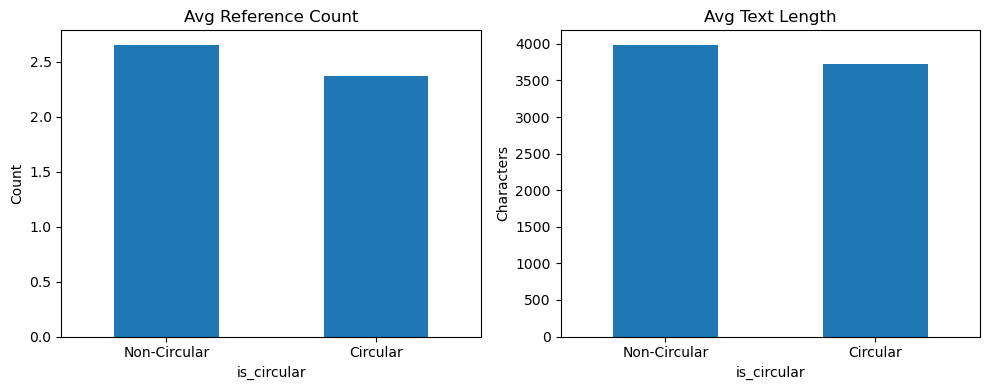

In [59]:
import matplotlib.pyplot as plt

# Bar plot for average number of references and text length
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Average references
ref_avg.plot(kind='bar', ax=ax[0], title="Avg Reference Count")
ax[0].set_xticklabels(['Non-Circular', 'Circular'], rotation=0)
ax[0].set_ylabel("Count")

# Average text length
len_avg.plot(kind='bar', ax=ax[1], title="Avg Text Length")
ax[1].set_xticklabels(['Non-Circular', 'Circular'], rotation=0)
ax[1].set_ylabel("Characters")

plt.tight_layout()
plt.show()


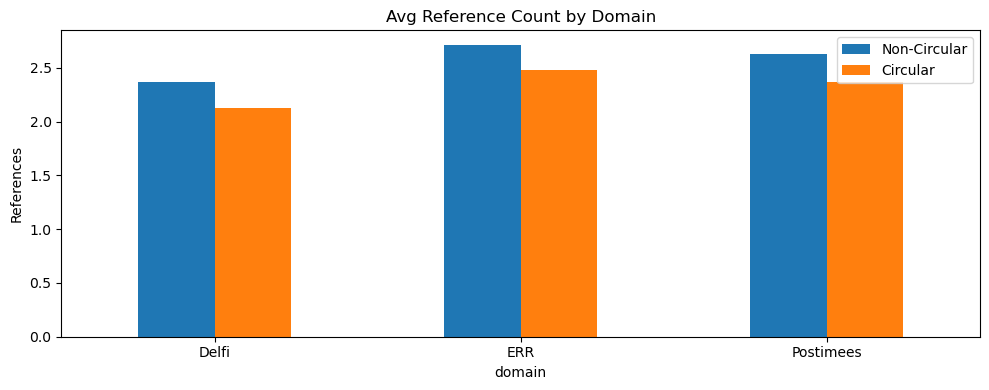

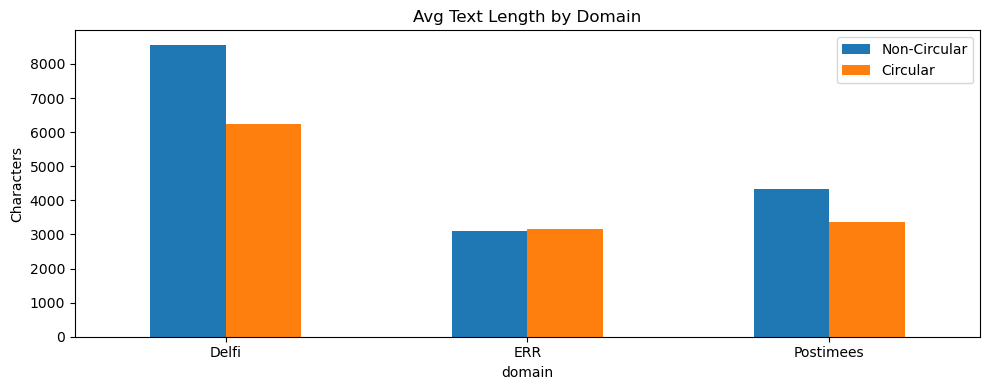

In [60]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load binary labels
df = pd.read_csv("all.csv", header=None, names=["url", "is_circular"])
df["is_circular"] = df["is_circular"].astype(bool)

# Load article data
with open("combined_filtered.json", "r", encoding="utf-8") as f:
    data = json.load(f)

stats = []

for _, row in df.iterrows():
    partial_url = row["url"]
    is_circular = row["is_circular"]
    match = next((full_url for full_url in data if partial_url in full_url), None)

    if match:
        content = data[match].get("content", "")
        references = data[match].get("references", {})
        if "err.ee" in match:
            domain = "ERR"
        elif "postimees" in match:
            domain = "Postimees"
        elif "delfi" in match:
            domain = "Delfi"
        else:
            domain = "Other"

        stats.append({
            "is_circular": is_circular,
            "reference_count": len(references),
            "text_length": len(content),
            "domain": domain
        })

df_stats = pd.DataFrame(stats)

# Plot: Avg reference count by domain and circularity
ref_avg = df_stats.groupby(["domain", "is_circular"])["reference_count"].mean().unstack()
ref_avg.plot(kind='bar', figsize=(10, 4), title="Avg Reference Count by Domain")
plt.ylabel("References")
plt.xticks(rotation=0)
plt.legend(["Non-Circular", "Circular"])
plt.tight_layout()
plt.show()

# Plot: Avg text length by domain and circularity
len_avg = df_stats.groupby(["domain", "is_circular"])["text_length"].mean().unstack()
len_avg.plot(kind='bar', figsize=(10, 4), title="Avg Text Length by Domain")
plt.ylabel("Characters")
plt.xticks(rotation=0)
plt.legend(["Non-Circular", "Circular"])
plt.tight_layout()
plt.show()
